**class Get Data**

In [1]:
class GeolifeTrajectoriesData():
    def __init__(self, SparkContext = sc, path = 'Geolife Trajectories 1.3/Data/*/*'):
        self.attributes = ['Latitude', 'Longitude', 'Altitude in feet', 'Date', 'Time']
        self.data = SparkContext.wholeTextFiles(path)\
                                .flatMap(lambda x:x[1].split('\r\n')[6:])\
                                .map(lambda x:x.split(','))\
                                .filter(lambda x:len(x) == 7)
                    
    def getRDD(self, cache = False):
        rdd = self.data.map(lambda x:[float(x[0]), float(x[1]), float(x[3]), x[5], x[6]])
        if cache:
            rdd = rdd.cache()
        return rdd
        
    def getDataFrame(self, cache = False):
        df = self.getRDD().toDF(self.attributes)
        if cache:
            df = df.cache()
        return df
        
    def getAttributes(self):
        return self.attributes

**Show the Data Frame**

In [2]:
data = GeolifeTrajectoriesData(sc, 'Geolife Trajectories 1.3/Data/130/*')
df = data.getDataFrame()
df.show()
df.printSchema()
print(df.count(),'Data points')

+---------+----------+----------------+----------+--------+
| Latitude| Longitude|Altitude in feet|      Date|    Time|
+---------+----------+----------------+----------+--------+
|39.975088| 116.33269|492.126135170604|2009-07-06|19:11:32|
| 39.97504|116.332806|491.743412073491|2009-07-06|19:11:33|
|39.975009|116.332997|491.676630577428|2009-07-06|19:11:34|
|39.975048|116.332932|491.403044619423|2009-07-06|19:11:35|
|39.974977| 116.33305|491.043900918635|2009-07-06|19:11:37|
|39.974967|116.333116|489.435272309711|2009-07-06|19:11:47|
|39.974931|116.333188|487.797303149606|2009-07-06|19:11:57|
|39.974927|116.333249|489.250744750656|2009-07-06|19:12:03|
|39.974953| 116.33331|487.910994094488|2009-07-06|19:12:12|
|39.974988|116.333359|486.979045275591|2009-07-06|19:12:17|
|39.975029|116.333311|486.138612204724|2009-07-06|19:12:24|
|39.974993|116.333368|485.249717847769|2009-07-06|19:12:28|
|39.975013|116.333424|484.258648293963|2009-07-06|19:12:35|
|39.975008|  116.3335|483.536105643045|2

**Plot the data**

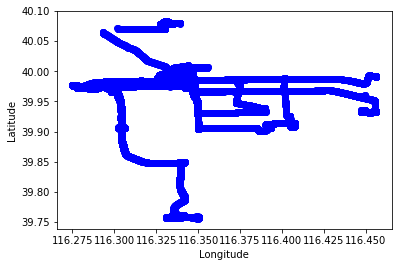

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

position = data.getRDD().map(lambda x:[x[0], x[1]]).collect()

plt.plot([p[1] for p in position], [p[0] for p in position], 'ob')
plt.xlabel('Longitude')
plt.ylabel('Latitude') 
plt.show()

**class Partition the Data**

In [4]:
k = 0.1
m = 0.05

def regionIds(datum):
        regions = []
        root_region = [int(datum[1]/k), int(datum[0]/k)]
        regions.append(root_region)
        is_left = True if (datum[1]<(root_region[0]-1)*k+m) else False #left
        is_right = True if (datum[1]>(root_region[0]+1)*k-m) else False #right
        is_up = True if (datum[0]<(root_region[1]-1)*k+m) else False #up
        is_down = True if (datum[0]>(root_region[1]+1)*k-m) else False #down

        if is_left:
            regions.append([(root_region[0]-1),root_region[1]])
            if is_up:
                regions.append([(root_region[0]-1),root_region[1]-1])
            elif is_down:
                regions.append([(root_region[0]-1),root_region[1]+1])
        elif is_right:
            regions.append([(root_region[0]+1),root_region[1]])
            if is_up:
                regions.append([(root_region[0]+1),root_region[1]-1])
            elif is_down:
                regions.append([(root_region[0]+1),root_region[1]+1])
        elif is_up:
            regions.append([(root_region[0]),root_region[1]-1])
        elif is_down:
            regions.append([(root_region[0]),root_region[1]+1])

        return regions

class PartitionedData():
    def __init__(self, input_data, SparkContext = sc):
        self.data = input_data.map(lambda x: [x[0],x[1]]).map(lambda x:[x,regionIds(x)])
    
    def getRDD(self, cache = False, region = [0,0]):
        rdd = self.data.map(lambda x: [x[1], x[0]]) if region==[0,0] else self.data.filter(lambda x: region in x[1]).map(lambda x: [x[1], x[0]])
        if cache:
            rdd = rdd.cache()
        return rdd
    
    def getDataFrame(self, cache = False):
        df = self.getRDD().toDF(self.attributes)
        if cache:
            df = df.cache()
        return df

**class Local DBSCAN**

In [5]:
from sklearn.cluster import DBSCAN

class LocalDBSCAN():
    def __init__(self, input_data, SparkContext = sc):
        self.data = PartitionedData(input_data.getRDD(), sc)
        self.region = self.data.getRDD(cache = True)\
                               .map(lambda x:x[0])\
                               .filter(lambda x:len(x) == 1)\
                               .map(lambda x:(x[0][0], x[0][1]))\
                               .distinct().collect()
    
    def getRegionDataRDD(self, cache = False):
        RDDs = list()
        for reg in self.region:
            rdd = self.data.getRDD(region = [reg[0], reg[1]]).map(lambda x:x[1])
            if cache:
                rdd = rdd.cache()
            RDDs.append(rdd)
        return RDDs
    
    def getLocalDBSCANRDD(self, eps=0.001, min_samples=100, n_jobs=8, noise = False, cache = False):
        RDDs = list()
        for reg in self.region:
            regionData = self.data.getRDD(region = [reg[0], reg[1]]).map(lambda x:x[1]).collect()
            result = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=n_jobs).fit_predict(regionData)
            if not noise:
                x, y, c = [], [], []
                X = [p[1] for p in regionData]
                Y = [p[0] for p in regionData]
                for i in range(len(result)):
                    if result[i] != -1:
                        x.append(X[i])
                        y.append(Y[i])
                        c.append(result[i])
                rdd = sc.parallelize([[a, b, e] for a, b, e in zip(x, y, c)])
            else:
                rdd = sc.parallelize(result)
            if cache:
                rdd = rdd.cache()
            RDDs.append(rdd)
        return RDDs

**Plot Partitioned Data**

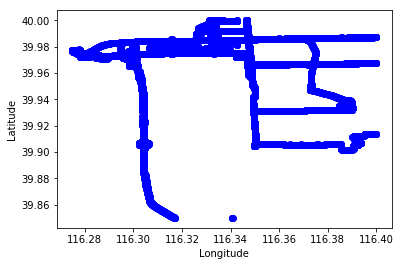

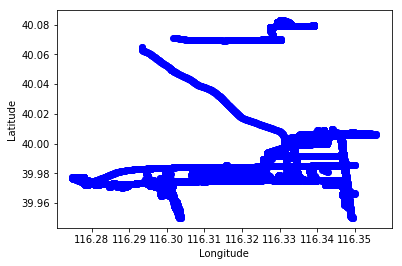

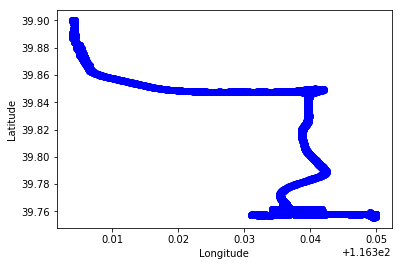

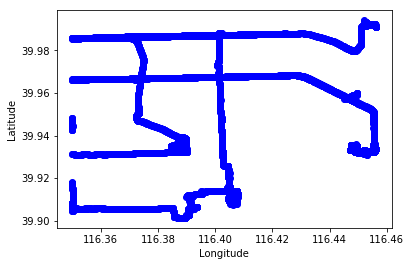

In [6]:
RegionDataRDDs = LocalDBSCAN(data).getRegionDataRDD(cache = True)
for rdd in RegionDataRDDs:
    position = rdd.collect()
    plt.plot([p[1] for p in position], [p[0] for p in position], 'ob')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude') 
    plt.show()

**Plot Local DBSCAN Data**

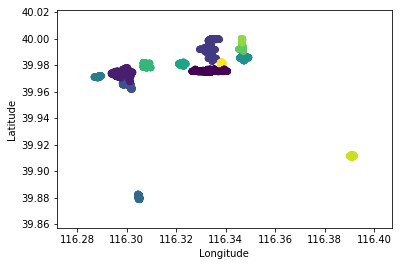

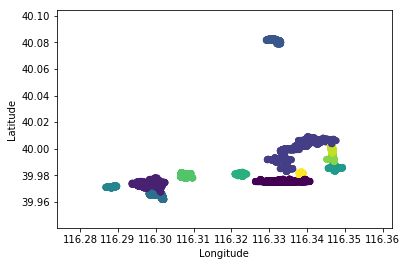

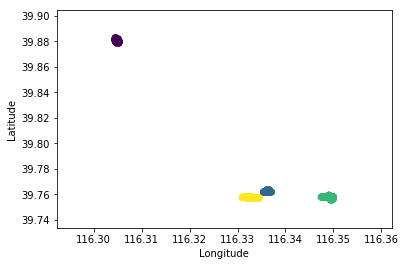

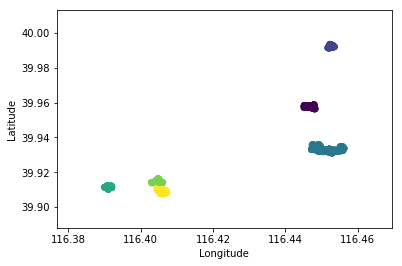

In [7]:
LocalDBSCANRDDs = LocalDBSCAN(data).getLocalDBSCANRDD(cache = True)
for rdd in LocalDBSCANRDDs:
    position = rdd.collect()
    plt.scatter([p[0] for p in position], [p[1] for p in position], c=[p[2] for p in position])
    plt.xlabel('Longitude')
    plt.ylabel('Latitude') 
    plt.show()

**Plot all Local DBSCAN Data**

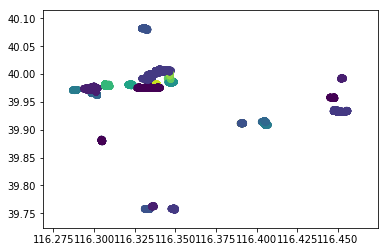

In [8]:
jam = []

for rdd in LocalDBSCANRDDs:
    jam.extend(rdd.collect())

plt.scatter([j[0] for j in jam], [j[1] for j in jam], c=[j[2] for j in jam])
plt.show()

**class Merge DBSCAN**

In [9]:
class MergeDBSCANRDD():
    def __init__(self, localRDDs):
        new_LocalDBSCANRDDs = list()
        for index,localRDD in enumerate(localRDDs):
            new_LocalDBSCANRDDs.append(localRDD.map(lambda x: [x[0],x[1],x[2]+index*100]).cache())
        self.localRDDs = new_LocalDBSCANRDDs
    def get_preprocessed_id_RDD(self):
        return self.localRDDs
    def get_preprocessed_union_RDD(self):
        union_rdd = sc.union(self.localRDDs).cache()
        return union_rdd
    def get_procedded_union(self):
        union = self.get_preprocessed_union_RDD().collect()
        count = len(union)
        for index, record in enumerate(union):
            uid = record[2]
            position = [record[0],record[1]]
            for i in range(index,count):
                if [union[i][0],union[i][1]] == position:
                    union[i][2] = uid
        return union
    def get_procedded_union_RDD(self):
        return sc.parallelize(self.get_procedded_union())
    def getDBSCANRDD(self, eps=0.01, min_samples=100, n_jobs=8, noise = False):
        data = self.get_preprocessed_union_RDD().map(lambda x: [x[0],x[1]]).collect()
        result = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=n_jobs).fit_predict(data)
        if not noise:
            x, y, c = [], [], []
            X = [p[0] for p in data]
            Y = [p[1] for p in data]
            for i in range(len(result)):
                if result[i] != -1:
                    x.append(X[i])
                    y.append(Y[i])
                    c.append(result[i])
            rdd = sc.parallelize([[a, b, e] for a, b, e in zip(x, y, c)])
            return rdd
        else:
            rdd = sc.parallelize(result)
            return rdd

**Plot Merge DBSCAN Data**

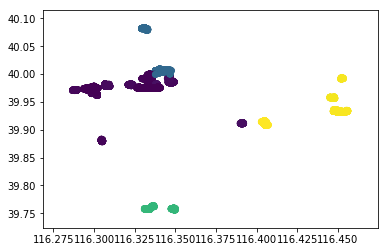

In [10]:
merge = MergeDBSCANRDD(LocalDBSCANRDDs).get_procedded_union()
plt.scatter([x[0] for x in merge], [y[1] for y in merge], c=[cls[2] for cls in merge])
plt.show()

**Plot Merge DBSCAN Data but done DBSCAN again**

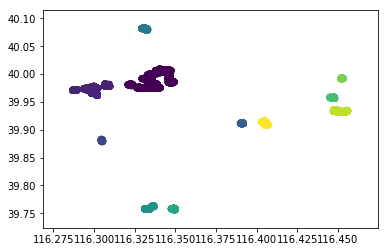

In [11]:
merge_DBSCAN = MergeDBSCANRDD(LocalDBSCANRDDs).getDBSCANRDD().collect()
plt.scatter([x[0] for x in merge_DBSCAN], [y[1] for y in merge_DBSCAN], c=[cls[2] for cls in merge_DBSCAN])
plt.show()